## Evaluation: Max. supported user request rate
* Generate measurements with OMNeT++, using the prepared `omnet-test` simulation code
* Convert them to csv using `scavetool x omnet-test/results/*.vec -o eval/measurements/max_rate.csv`
* Read and analyze using Python: https://docs.omnetpp.org/tutorials/pandas/

Evaluated service: Video streaming service (see below). 
* 30 repetitions á 10min
* Cache hit ratio: 70%
* User request rates: 0.25, 0.5, 0.75, 1, 1.25 (requests/s)
    * Translates to intervals of: 4s, 2s, 1.333s, 1s, 0.8s
* VNF processing times:
    * Cache (upstream): exp(0.5s)
    * Server: exp(3s)
    * Video optimizer: exp(0.5s)
    * Ad insertion: exp(0.5s)
    * Cache (downstream): exp(0.5s)

![omnet](../docs/omnet.png)

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from subprocess import call
%matplotlib inline

In [9]:
# convenience functions for parsing numbers and arrays in csv correctly
def parse_if_number(s):
    try: 
        return float(s)
    except: 
        return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

# load measurements from results folder
results = pd.read_csv('measurements/max_rate.csv', converters = {
                    'attrvalue': parse_if_number,
                    'binedges': parse_ndarray,
                    'binvalues': parse_ndarray,
                    'vectime': parse_ndarray,
                    'vecvalue': parse_ndarray})
results.head()

,run,type,module,name,attrname,attrvalue,value,vectime,vecvalue
0,VideoFixed-121-20180809-15:53:57-13604,runattr,NaN,NaN,configname,VideoFixed,NaN,None,None
1,VideoFixed-121-20180809-15:53:57-13604,runattr,NaN,NaN,datetime,20180809-15:53:57,NaN,None,None
2,VideoFixed-121-20180809-15:53:57-13604,runattr,NaN,NaN,experiment,VideoFixed,NaN,None,None
3,VideoFixed-121-20180809-15:53:57-13604,runattr,NaN,NaN,inifile,omnetpp.ini,NaN,None,None
4,VideoFixed-121-20180809-15:53:57-13604,runattr,NaN,NaN,iterationvars,$0=0.8s,NaN,None,None


In [10]:
# return transformed data frame only containing the recorded vectors
# replace run number with the corresponding parameter values, saved as iterationvars
def vectors(results):
    # select matching parameters per row based on 'run' 
    itervars = results[results.attrname == 'iterationvars'] 
    params = []
    for index, row in results.iterrows():
        params.append(itervars.loc[itervars.run == row.run].iloc[0].attrvalue)
       
    # add param column
    results['param'] = pd.Series(params, index=results.index)
    
    # return filtered results (only vectors, only relevant columns)
    return pd.DataFrame(data=results[results.type == 'vector'], columns=['module', 'name', 'vectime', 'vecvalue', 'param'])
        
vecs = vectors(results)
vecs.head()

,module,name,vectime,vecvalue,param
4350,VideoFixed.U_T0,processingDelay,"[0.0, 0.8, 1.6, 2.4, 3.2, 4.0, 4.8, 5.6, 6.4, ...","[0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, ...",$0=0.8s
4351,VideoFixed.C_T3,queueLength0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",$0=0.8s
4352,VideoFixed.C_T3,queueLength1,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",$0=0.8s
4353,VideoFixed.S_T0,queueLength0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, ...",$0=0.8s
4354,VideoFixed.V_T0,queueLength0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",$0=0.8s


In [11]:
# return df with separate rows for each vector element of vec_name (columns module, param, time, <vec_name>)
# select only rows of 'only_modules'
def vector_values(vectors, vec_name, only_modules=None):
    vec_values = {'module': [], 'request_interval': [], 'rate': [], 'time': [], vec_name: []}
    selected_vecs = vectors[vectors['name'] == vec_name]
    for index, row in selected_vecs.iterrows():     
        # unroll vector into separate rows
        if only_modules is None or row['module'][11:] in only_modules:               
            for i in range(row['vectime'].size):
                vec_values['module'].append(row['module'][11:])      # drop "VideoFixed." prefix
                vec_values['request_interval'].append(row['param'][3:])     # transform '$0=0.5s' into '0.5s'
                vec_values['rate'].append(round(1.0/float(row['param'][3:-1]), 2))
                vec_values['time'].append(row['vectime'][i])
                vec_values[vec_name].append(row['vecvalue'][i])
            
    return pd.DataFrame(data=vec_values)

### End-to-end delay with increasing rate

In [12]:
# get tokenInDelays but only at user U_P0
end2end_delays = vector_values(vecs, 'tokenInDelay', only_modules=['U_P0'])
end2end_delays.tail()

,module,request_interval,rate,time,tokenInDelay
66066,U_P0,4s,0.25,580.050285,0.050285
66067,U_P0,4s,0.25,584.212802,0.212802
66068,U_P0,4s,0.25,588.345066,0.345066
66069,U_P0,4s,0.25,592.561201,0.561201
66070,U_P0,4s,0.25,596.334914,0.334914


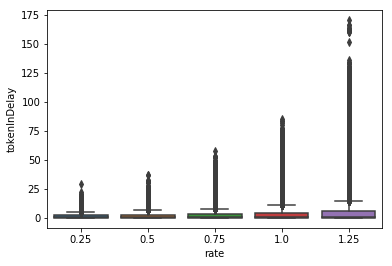

In [13]:
g = sns.boxplot('rate', 'tokenInDelay', data=end2end_delays)

c:\users\stefan\git-repos\work\venv\qpn\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


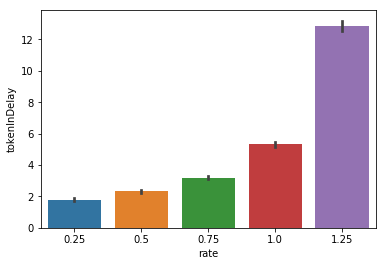

In [14]:
sns.barplot('rate', 'tokenInDelay', data=end2end_delays)

### Queue lengths
For different VNFs to identify the bottleneck

In [15]:
qlengths = vector_values(vecs, 'queueLength0', only_modules=['C_T0', 'S_T0', 'V_T0', 'A_T0'])
qlengths.head()

,module,request_interval,rate,time,queueLength0
0,S_T0,0.8s,1.25,0.0,0.0
1,S_T0,0.8s,1.25,1.0,0.0
2,S_T0,0.8s,1.25,2.0,0.0
3,S_T0,0.8s,1.25,3.0,0.0
4,S_T0,0.8s,1.25,4.0,0.0


In [16]:
# map module names to proper VNF names
mapping = {
    'C_T0': 'cache',
    'S_T0': 'server',
    'V_T0': 'vid. opt.',
    'A_T0': 'ad ins.'
}
qlengths['VNF'] = qlengths['module'].map(lambda x: mapping[x])
qlengths.head()

,module,request_interval,rate,time,queueLength0,VNF
0,S_T0,0.8s,1.25,0.0,0.0,server
1,S_T0,0.8s,1.25,1.0,0.0,server
2,S_T0,0.8s,1.25,2.0,0.0,server
3,S_T0,0.8s,1.25,3.0,0.0,server
4,S_T0,0.8s,1.25,4.0,0.0,server


c:\users\stefan\git-repos\work\venv\qpn\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


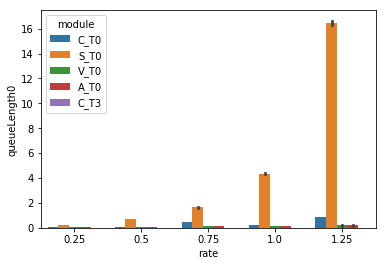

In [17]:
# mean queue length per request rate and module
sns.barplot('rate', 'queueLength0', hue='module', hue_order=['C_T0', 'S_T0', 'V_T0', 'A_T0', 'C_T3'], data=qlengths)

c:\users\stefan\git-repos\work\venv\qpn\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[(0, 5)]

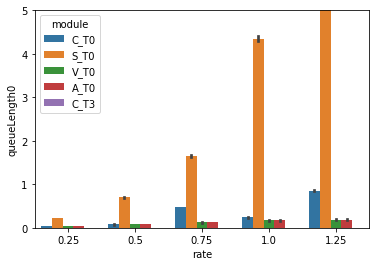

In [18]:
g = sns.barplot('rate', 'queueLength0', hue='module', hue_order=['C_T0', 'S_T0', 'V_T0', 'A_T0', 'C_T3'], data=qlengths)
g.set(ylim=(0, 5))

c:\users\stefan\git-repos\work\venv\qpn\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[None]

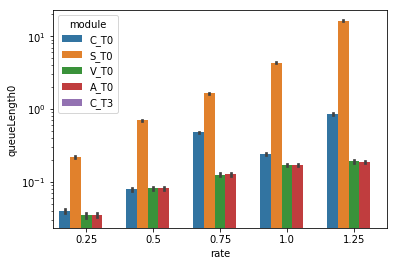

In [19]:
g = sns.barplot('rate', 'queueLength0', hue='module', hue_order=['C_T0', 'S_T0', 'V_T0', 'A_T0', 'C_T3'], data=qlengths)
g.set(yscale='log')

### Paper plot: Delay and queue lengths

In [20]:
# global seaborn settings
sns.set(font_scale=1.5)
sns.set_style("white")

c:\users\stefan\git-repos\work\venv\qpn\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


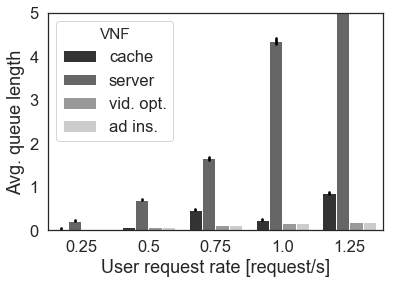

In [21]:
g = sns.barplot(
    'rate', 'queueLength0', data=qlengths,
    hue='VNF', hue_order=['cache', 'server', 'vid. opt.', 'ad ins.'],
    palette='gray', errcolor='black'
)
g.set(
    xlabel='User request rate [request/s]',
    ylabel='Avg. queue length',
    ylim=(0, 5)
)

fig = g.get_figure()
fig.savefig('plots/queue-length.pdf', bbox_inches='tight')

c:\users\stefan\git-repos\work\venv\qpn\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[(0, 5), Text(0,0.5,'Avg. queue length')]

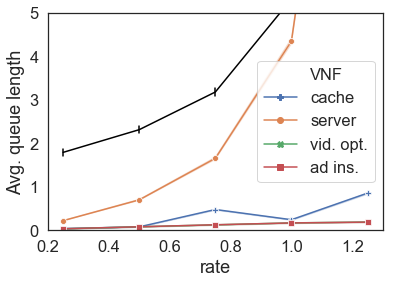

In [22]:
## delay and qlengths in once. too complicated and hard to read...
# plot delay
g1 = sns.lineplot('rate', 'tokenInDelay', data=end2end_delays,
                err_style='bars', color='black')
g1.set(
    xlabel='User request rate [request/s]',
    ylabel='Avg. end-to-end delay [s]',
    ylim=(0,15)
)

# plot queue length
# ax2 = plt.twinx()
g2 = sns.lineplot(
    'rate', 'queueLength0', data=qlengths,
    hue='VNF', hue_order=['cache', 'server', 'vid. opt.', 'ad ins.'], 
    style='VNF', markers=True, dashes=False
)
g2.set(
    ylabel='Avg. queue length',
    ylim=(0, 5),
)

# export
#fig = g.get_figure()
#fig.savefig('plots/bottleneck.pdf', bbox_inches='tight')